In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

# Structure From Motion

We can calculate motion from points on consecutive images. Using [Epipolar geometry](#Epipolar-Geometry), we can look at a few images, find the same points between the images, and calculate the map of where the images were taken in the 3D space.

## Epipolar Geometry

So, Epipolar geometry is basically a way for us to calculate the triangles created by the consecutive images, and the object that's in focus. 

![Epipolar-Geometry][logo]

[logo]: https://docs.opencv.org/3.3.0/epipolar.jpg "Epipolar Geometry"


With these triangles, were able to map the world behind the lens.

```
TODO
----
Change variable names to match the book rather than the video
http://ksimek.github.io/2012/08/22/extrinsic/
```


- The optical centers of the two cameras, a point $P$, and the image points $p_{0}$ and $p_{1}$ of $P$ all lie in the same plane (epipolar plane)
- These vectors are co-planar: $\vec{C_{0}p_{0}}, \vec{C_{1}p_{1}}, \vec{C_{0}C_{1}}$

- Now, instead of treating $p_{0}$ as a point, treat it as a 3D direction vector:

$$p_{0} = C_{0}\begin{pmatrix}
           x_{0} \\
           y_{0} \\
           1
         \end{pmatrix} $$
Here, we assume "normalized" image coordinates (focal length of $1$)

- The same can be applied in the second photo's coordinate system:
$$p_{1} = C_{1}\begin{pmatrix}
           x_{1} \\
           y_{1} \\
           1
         \end{pmatrix} $$
- To find the direction of the second photo's coordinate system in the first photo, you need to apply some rotation matrix $R$ from the first photo's point, $p_{0}$, to the second photo's point, $p_{1}$.
$$ ^{C_{0}}_{C_{1}}Rp_{1}$$
- Don't forget! These vectors determine direction and not the starting point.

- We know that the points $p_{0}$ and $p_{1}$ are coplanar. This gives us the constraint
$$\vec{C_{0}p_{0}} \cdot \vec{C_{0}C_{1}} \times \vec{C_{1}p_{1}} =0 $$

- We can write the coplanar constraint as 
$$p_{0} \cdot (t \times Rp_{1}) = 0 $$

  - Where $R$ is the rotation of the first photo with respect to the second photo
  $$^{C_{0}}_{C_{1}}R $$
  - and $t$ is the translation of the first photo's origin with respect to the first photo
  $$ ^{C_{0}}t_{C_{1orig}} $$
  - Remember that the pose, $H$, of the first photo with respect to the second photo is a homogeneous transformation matrix:
  $$ ^{C_{0}}_{C_{1}}H = \begin{pmatrix}
  ^{C_{0}}_{C_{1}}R & ^{C_{0}}t_{C_{1orig}} \\
  0 & 1
  \end{pmatrix}$$
  
- We can replace the vector product with a skew symmetric-matrix for $t$
$$ p^{t}_{0}[t]_{x}R_{p_{1}} = 0$$
- We will let the essential matrix be the 3x3 matrix: $E=[t]_x R$.

- With all of this, we have the epipolar constraint:
$$ p^{T}_{0} E p_{1} = 0$$

$$
\begin{pmatrix}x_{0} & y_{0} & 1\end{pmatrix}
\begin{pmatrix}
    E_{11} & E_{12} & E_{13} \\
    E_{21} & E_{22} & E_{23} \\
    E_{31} & E_{32} & E_{33}\end{pmatrix}
\begin{pmatrix}x_{1} \\ y_{1} \\ 1\end{pmatrix}
=0
$$




### Essential Matrix
- The matrix $E$, that relates the image of a point in one camera to its image in the other camera, given a translation and rotation.
- With known coordinates, we can project/render images.


In [2]:
image_size = 300
image_1 = np.zeros((image_size, image_size))

With a blank image, we can define pose, $H$. This will be composed of the focal length $f$ and the translation to position 0.

In [3]:
f = image_size
u_0 = image_size/2
v_0 = image_size/2
H = np.matrix([
    [f, 0, u_0],
    [0, f, v_0],
    [0, 0, 1]])

With the pose defined, we can define points on the cube.

In [4]:
points = np.array([
    [0, 2, 0, 1], 
    [0, 1, 0, 1],
    [0, 0, 0, 1],
    [0, 2, -1, 1],
    [0, 1, -1, 1],
    [0, 0, -2, 1],
    [0, 2, -2, 1],
    [0, 1, -2, 1],
    [0, 0, -2, 2],
    [1, 0, 0, 1],
    [2, 0, 0, 1],
    [1, 0, -1, 1],
    [2, 0, -1, 1],
    [1, 0, -2, 1],
    [2, 0, -2, 1]
]).transpose()

With the points on the cube defined, we can rotate and translate the camera into its first position. We can do this by using an extrinsic camera parameter matrix, `M`. This matrix represents the camera rotated 120 degrees in the x coordinate system and 60 degrees in the z coordinate system. The camera is also translated 5 units in the z direction.

In [5]:
a_x = 120 * (math.pi/180)
a_y = 0 * (math.pi/180)
a_z = 60 * (math.pi/180)
translate_0 = np.matrix([[0], [0], [5]])
R_x = np.matrix([
    [1, 0, 0],
    [0, math.cos(a_x), -math.sin(a_x)],
    [0, math.sin(a_x), math.cos(a_x)]
])
R_y = np.matrix([
    [math.cos(a_y), 0, math.sin(a_y)],
    [0, 1, 0],
    [-math.sin(a_y), 0, math.cos(a_y)]
])
R_z = np.matrix([
    [math.cos(a_z), -math.sin(a_z), 0], 
    [math.sin(a_z), math.cos(a_z), 0], 
    [0, 0, 1]
])
M = np.append(R_x * R_y * R_z, translate_0, 1)
points_1 = M * points

With the first image's focal length, $f_1$, and the point's distance from the camera, $Z_1$, set, we can render the individual points, $p_i$.

$$p_i = (f_1 / Z_1)P_1$$

We then need to convert the normalized image points to be unnormalized.

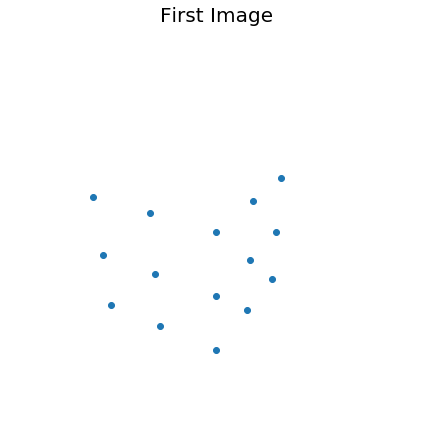

In [6]:
points_1[0,:] = points_1[0,:] / points_1[2,:]
points_1[1,:] = points_1[1,:] / points_1[2,:]
points_1[2,:] = points_1[2,:] / points_1[2,:]
u_1 = H * points_1
for row in u_1.transpose():
    image_1[int(row[0, 0])-2:int(row[0, 0])+2, int(row[0, 1])-2:int(row[0, 1])+2] = 255
plt.figure(1, figsize = (7.5,7.5))
axes = plt.gca()
axes.scatter(
    [x[0] for x in u_1.transpose()[:,0].tolist()],
    [300-y[0] for y in u_1.transpose()[:,1].tolist()]
)
axes.set_xlim([0, 300])
axes.set_ylim([0, 300])
axes.set_title("First Image", size=20)
axes.axis("off")
plt.show()

With the first image rendered, we can use the same calculations to move the camera again.

In [7]:
a_x = 0 * (math.pi/180)
a_y = -25 * (math.pi/180)
a_z = 0 * (math.pi/180)
translate_1 = np.matrix([[3], [0], [1]])
R_x = np.matrix([
    [1, 0, 0],
    [0, math.cos(a_x), -math.sin(a_x)],
    [0, math.sin(a_x), math.cos(a_x)]
])
R_y = np.matrix([
    [math.cos(a_y), 0, math.sin(a_y)],
    [0, 1, 0],
    [-math.sin(a_y), 0, math.cos(a_y)]
])
R_z = np.matrix([
    [math.cos(a_z), -math.sin(a_z), 0], 
    [math.sin(a_z), math.cos(a_z), 0], 
    [0, 0, 1]
])
M_c1 = np.append(R_x * R_y * R_z, translate_1, 1)

```
TODO
----
Create variable names for the camera positions.
```

With the extrinsic matrix created for the translation of camera 1 to camera 2, the different poses can be found. The pose of the start of the camera with respect to the camera's first position is created by appending the a row for rotation. The same is applied to the pose of the second position to the first position.

In [8]:
H_m_c1 = np.vstack([M, [0, 0, 0, 1]])
H_c2_c1 = np.vstack([M_c1, [0, 0, 0, 1]])
H_c1_c2 = np.linalg.inv(H_c2_c1)
H_m_c2 = H_c1_c2 * H_m_c1

In [9]:
R_m_c2 = H_m_c2[0:3,0:3]
translate_0_2 = H_m_c2[0:3,3]
M = np.append(R_m_c2, translate_0_2, 1)

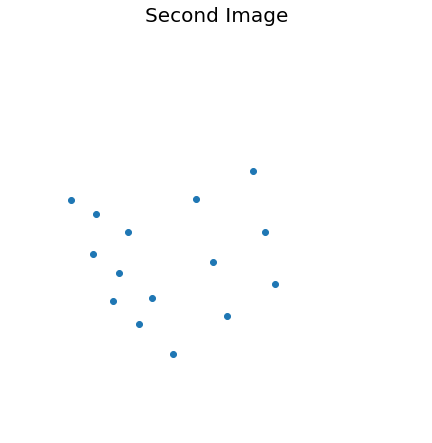

In [10]:
image_2 = np.zeros((image_size, image_size))
points_2 = np.vstack([
    (M * points)[0,:] / (M * points)[2,:],
    (M * points)[1,:] / (M * points)[2,:],
    (M * points)[2,:] / (M * points)[2,:]
])
u_2 = H * points_2
for row in u_2.transpose():
    image_2[int(row[0, 0])-2:int(row[0, 0])+2, int(row[0, 1])-2:int(row[0, 1])+2] = 255
    
plt.figure(1, figsize = (7.5,7.5))
axes = plt.gca()
axes.scatter(
    [x[0] for x in u_2.transpose()[:,0].tolist()],
    [300-y[0] for y in u_2.transpose()[:,1].tolist()]
)
axes.set_xlim([0, 300])
axes.set_ylim([0, 300])
axes.set_title("Second Image", size=20)
axes.axis("off")
plt.show()

In [11]:
E = np.matrix([
    [0, -float(translate_1[2][0]), float(translate_1[1][0])],
    [float(translate_1[2][0]), 0, float(-translate_1[0][0])],
    [-float(translate_1[1][0]), float(translate_1[0][0]), 0]
]) * M_c1
E = np.delete(E, -1, axis=1)
E

matrix([[ 0.        , -1.        ,  0.        ],
        [-0.361547  ,  0.        , -3.14154162],
        [ 0.        ,  3.        ,  0.        ]])

### Calculating the Essential Matrix

Remember the Essential matrix, $E$? It relates the image of a point in one image to its location in another image by a given rotation and/or translation,
$$ p^{T}_{0} E p_{1} = 0 \text{,}$$
where
$$E=[t]_x R\text{.}$$

We can calculate $E$ if we know the pose between the two images. We can also calculate $E$ from a set of known point correspondences, like the points in both $p_0$ and $p_1$.

Now, $E$ is a 3x3 matrix with 9 unknowns. Again, there is a scale factor, which helps us out by letting us know that there are actually only 8 unknowns. With 8 equations, we can calculate $E$ from 8 or more related points between images. We can simplify the equation as follows:

$$
\begin{pmatrix}x_{0} & y_{0} & 1\end{pmatrix}
\begin{pmatrix}
    E_{11} & E_{12} & E_{13} \\
    E_{21} & E_{22} & E_{23} \\
    E_{31} & E_{32} & E_{33}\end{pmatrix}
\begin{pmatrix}x_{1} \\ y_{1} \\ 1\end{pmatrix}
=0
$$

$$
\begin{pmatrix}x_{0} & y_{0} & 1\end{pmatrix}
\begin{pmatrix}
    E_{11}x_{1} + E_{12}y{1} + E_{13} \\
    E_{21}x_{1} + E_{22}y_{1} + E_{23} \\
    E_{31}x_{1} + E_{32}y_{1} + E_{33}\end{pmatrix} = 0
$$

$$
\begin{split}
E_{11}x_{1}x_{0} &+ E_{12}y{1}x_{0}  &+ E_{13}x_{0} &+\\
E_{21}y_{0}x_{1} &+ E_{22}y_{0}y_{1} &+ E_{23}y_{0} &+\\
E_{31}x_{1}      &+ E_{32}y_{1}      &+ E_{33}      &= 0
\end{split}
$$

With this equation, we can write it as a matrix equation by separating the unknowns from the known variables.

$$
\begin{pmatrix} x_{0}x_{1} & x_{0}y_{1} & x_{0} & y_{0}x_{1} & y_{0}y_{1} & y_{0} & x_{1} & y_{1} & 1 \end{pmatrix}
\begin{pmatrix} E_{11} \\ E_{12} \\ E_{13} \\ \vdots \\ E_{33}\end{pmatrix} = 0
$$

With this system of homogeneous equations, we can ignore the trivial solution, $x=0$. Without the trivial solution, we only have the _unique_ solution. While we cannot calculate this exactly, we can use principal component analysis to find an answer with small error. Our minimization will be: 
$$\sum (p^{T}_{0} E p_{1})^{2} \text{.}$$


We can use singular value decomposition, SVD, to solve for the essential matrix:

$$
A = U D V^{T} \text{,}
$$

where

$$
A = \begin{pmatrix} x_{0}x_{1} & x_{0}y_{1} & x_{0} & y_{0}x_{1} & y_{0}y_{1} & y_{0} & x_{1} & y_{1} & 1 \end{pmatrix}\text{.}
$$

The solution of $E$ is the column of $V$ corresponding to the only null singular value of $A$. In this scenario, the rightmost column of $V$ is the solution we are looking for.

---

The first step in this process is to scale and translate the image points so that the centroid of all the points is found at the origin. In order to do this, we first need to calculate the centroids of all the ($x$, $y$) coordinates found in the first image.

In [12]:
x_n = points_1[0:2, :]
N = x_n.shape[1]
t = np.sum(x_n, axis=1) / N

With this, we can center the points to the origin, find the distance from the centroid of all the centered points, `dc`, and calculate a scale factor `s` that we use to scale the points to have an average distance of $\sqrt{2}$ from the origin.

In [13]:
xnc = x_n - t * np.ones((1,N))
dc = np.sqrt(np.sum(np.power(xnc, 2).transpose(), axis=1))
d_avg = 1 / N * np.sum(dc)
s = np.sqrt(2) / d_avg

Now we can create the skew-symmetric matrix, $t$, with the scale factor and the distance from the centroid we calculated earlier.

In [14]:
t_1 = np.zeros((2, 2), float)
np.fill_diagonal(t_1, s)
t_1 = np.vstack([np.hstack([t_1, -s * t]), [0, 0, 1]])
points_1_scaled = t_1 * points_1

We can do the same thing with the second set of points we found earlier.

In [15]:
x_n = points_2[0:2, :]
N = x_n.shape[1]
t = np.sum(x_n, axis=1) / N
xnc = x_n - t * np.ones((1,N))
dc = np.sqrt(np.sum(np.power(xnc, 2).transpose(), axis=1))
d_avg = 1 / N * np.sum(dc)
s = np.sqrt(2) / d_avg
t_2 = np.zeros((2, 2), float)
np.fill_diagonal(t_2, s)
t_2 = np.vstack([np.hstack([t_2, -s * t]), [0, 0, 1]])
points_2_scaled = t_2 * points_2

In order to do our SVD, we first need to create the $A$ matrix:
$$A = \begin{pmatrix} x_{0}x_{1} & x_{0}y_{1} & x_{0} & y_{0}x_{1} & y_{0}y_{1} & y_{0} & x_{1} & y_{1} & 1 \end{pmatrix}\text{.}$$

Because we have $n$ unique points, the $A$ matrix will be $n \times 9$.

In [16]:
A = np.hstack([
    np.multiply(points_1_scaled[0,:].transpose(), points_2_scaled[0,:].transpose()),
    np.multiply(points_1_scaled[0,:].transpose(), points_2_scaled[1,:].transpose()),
    points_1_scaled[0,:].transpose(),
    np.multiply(points_1_scaled[1,:].transpose(), points_2_scaled[0,:].transpose()),
    np.multiply(points_1_scaled[1,:].transpose(), points_2_scaled[1,:].transpose()),
    points_1_scaled[1,:].transpose(),
    points_2_scaled[0,:].transpose(),
    points_2_scaled[1,:].transpose(),
    np.matrix(np.ones(15)).transpose()
])

With the $A$ matrix created, we can calculate the SVD of $A$.

In [17]:
[U, D, V] = np.linalg.svd(A)
x = V[8, :]
E_scaled = np.reshape(V[8, :].tolist(), (3,3))

Since we decomposed the matrix, we will need to force $\text{rank}(E)=2$ and equal Eigenvalues in the scaled essential matrix.

In [18]:
[U, D, V] = np.linalg.svd(E_scaled)
E_scaled = U * np.diag([1, 1, 0]) * V.transpose()

In [19]:
E_compute =  t_1.transpose() * E_scaled * t_2
E_compute

matrix([[ 2.45762485e-02,  0.00000000e+00,  2.86903168e-03],
        [ 0.00000000e+00, -1.72134999e+01,  1.22562695e+00],
        [ 9.64260721e-04,  1.21033188e+00, -8.60648732e-02]])

### Recovering Motion From The Essential Matrix

With the essential matrix, you can recover relative motion between images. We know that the Essential matrix is composed of the translation and rotation:

$$E=[t]_x R\text{.}$$

So how do we recover the translation and rotation of the matrix? Singular value decomposition of course!

$$E = U D V^{T}\text{,}$$

The translation, $t$, is either $u_3$ or $-u_3$, where $u_3$ is the last column of $U$. The rotation, $R$ is either $UWV^{T}$ or $UW^{T}V^{T}$, where

$$
W = \begin{pmatrix}
0 & -1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix} \text{.}
$$

This gives us 4 possible solutions. Luckily, 3 of the solutions support ideas that the points are behind the camera. We can rule these out. Our solution is homogeneous, which means that we can scale it by any constant, 

$$
kE=k[t]_x R
\text{,}
$$

and get valid results. This gives us a correct rotation, $R$, but a translation, $t$, of an arbitrary amount.

---

First, we can calculate the SVD of $E$ and define $W$.

In [20]:
U, D, VT = np.linalg.svd(E)
U[:,[0, 1]] = U[:,[1, 0]]
V = VT.transpose()
V[:,[0, 1]] = V[:,[1, 0]]
W = np.matrix([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]
])

Now, we can calculate our 4 possible solutions.

In [21]:
results = [
    np.vstack([np.hstack([U@W@V.transpose(),  U[:,2]]), [0,0,0,1]]),
    np.vstack([np.hstack([U@W@V.transpose(), -U[:,2]]), [0,0,0,1]]),
    np.vstack([np.hstack([U@W.transpose()@V.transpose(),  U[:,2]]), [0,0,0,1]]),
    np.vstack([np.hstack([U@W.transpose()@V.transpose(), -U[:,2]]), [0,0,0,1]])
]

With these results, we can reconstruct the points in 3D space. So, given the hypothesized pose, we can construct a model that follows the constrains given by the projections:

$$
Z_{1}p_{1}=M_{1}P \\
Z_{2}p_{2}=M_{2}P 
$$

where

$$
M_{1} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0
\end{pmatrix}
$$

$$
M_{2} = \begin{pmatrix}
r_{11} & r_{12} & r_{13} & t_{x} \\
r_{21} & r_{22} & r_{23} & t_{y} \\
r_{31} & r_{32} & r_{33} & t_{z}
\end{pmatrix}
=
\begin{pmatrix}
^{2}_{1}R & ^{2}t_{1orig}
\end{pmatrix}
$$

So since the projected point,$p_{1}$, and the observed point, $M_{1}P$, are parallel, their cross product should be $0$. The same can be said with the projected points of the second image. This gives us the constraint:

$$
p_{1}\times M_{1}P=0\\
p_{2}\times M_{2}P=0
$$

We can solve for $P$ by using least squares. 

$$
\begin{pmatrix}
[(p_{1})_x] M_{1} \\
[(p_{2})_x] M_{2}
\end{pmatrix}
P = 0
$$

---

First, we can declare the necessary identity matrix, `M_1`.

In [22]:
M_1 = np.matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0]
])

Then, we declare our projections using the last point relationship in the images.

In [23]:
p_1_x = np.matrix([
    [0, -points_1.transpose()[-1, 2], points_1.transpose()[-1, 1]],
    [points_1.transpose()[-1, 2], 0, -points_1.transpose()[-1, 0]],
    [-points_1.transpose()[-1, 1], points_1.transpose()[-1, 0], 0]
])
p_2_x = np.matrix([
    [0, -points_2.transpose()[-1, 2], points_2.transpose()[-1, 1]],
    [points_2.transpose()[-1, 2], 0, -points_2.transpose()[-1, 0]],
    [-points_2.transpose()[-1, 1], points_2.transpose()[-1, 0], 0]
])

Now, we can iterate over our results and find which of the results yields 3D points in front of each camera.

In [24]:
for result in results:
    if np.linalg.det(result[0:2,0:2]) < 0:
        result = -result
    U, D, V = np.linalg.svd(
        np.vstack([
            [p_1_x @ M_1],
            [p_2_x @ np.linalg.inv(result)[0:3,:]]
        ])
    )
    P = V[-1]
    P_1_est = P / P[0,-1]
    P_2_est = np.linalg.inv(result) @ P_1_est.transpose()
    if P_1_est[2,0] > 0 and P_2_est[2,0] > 0:
        answer = -result

Once we have a found the answer, we can reconstruct the points in 3D by using the estimated $M_{2}$ matrix.

In [25]:
M_2_est = np.linalg.inv(answer)[0:3,:]
P_est = []
for idx in range(0, points_1.shape[1]):
    p_1_x = np.matrix([
        [0, -points_1.transpose()[idx, 2], points_1.transpose()[idx, 1]],
        [points_1.transpose()[idx, 2], 0, -points_1.transpose()[idx, 0]],
        [-points_1.transpose()[idx, 1], points_1.transpose()[idx, 0], 0]
    ])
    p_2_x = np.matrix([
        [0, -points_2.transpose()[idx, 2], points_2.transpose()[idx, 1]],
        [points_2.transpose()[idx, 2], 0, -points_2.transpose()[idx, 0]],
        [-points_2.transpose()[idx, 1], points_2.transpose()[idx, 0], 0]
    ])
    U, D, V = np.linalg.svd(
        np.vstack([
            p_1_x @ M_1,
            p_2_x @ M_2_est
        ])
    )
    P = V[-1]
    P_est.append((P / P[0,-1]).tolist()[0][0:3]) 

Now, we can plot these 3D coordinates on a graph.

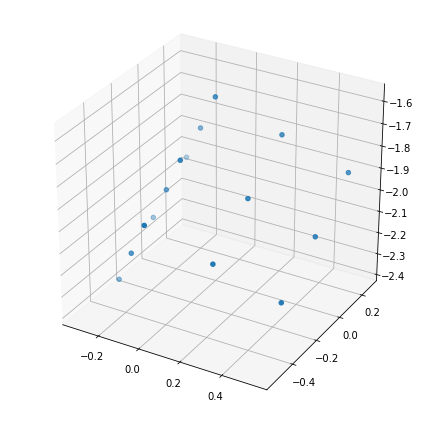

In [26]:
fig = plt.figure(figsize = (7.5,7.5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    [point[0] for point in P_est],
    [point[1] for point in P_est],
    [point[2] for point in P_est]
)
plt.show()

Looking at the graph, the points remain on the face of the cube.

### Epipolar Lines

You can draw any line on a 2D plane with the equation $ax + by + c = 0$. The issue we face while trying to draw lines between these points, is that you can scale this equation by any constant, $k$, and the constraint is still meet: $(ka)x+(kb)y + (kc)=0$.

So, if we say that a line may be represented as a set of homogeneous coordinates,

$$l = (a,b,c)^{T}\text{,}$$

we can say that the point $p$ lies on the line $l$ if and only if $p^{T}l=0$

$$p^{T}l=
\begin{pmatrix}x & y & z\end{pmatrix}
\begin{pmatrix}a \\ b \\ c \end{pmatrix}
=ax +by + cz
$$

With that out of the way, the constraint of the epipolar line, 

$$p_{0}^{T} E p_{1} = 0 \text{,}$$

allows us to draw lines on the images that are on the epipolar plane

$$
\begin{pmatrix}x_{0} & y_{0} & 1\end{pmatrix}
\begin{pmatrix}a \\ b \\ c \end{pmatrix} = 
ax_{0} + by_{0} + c = 0\text{.}
$$

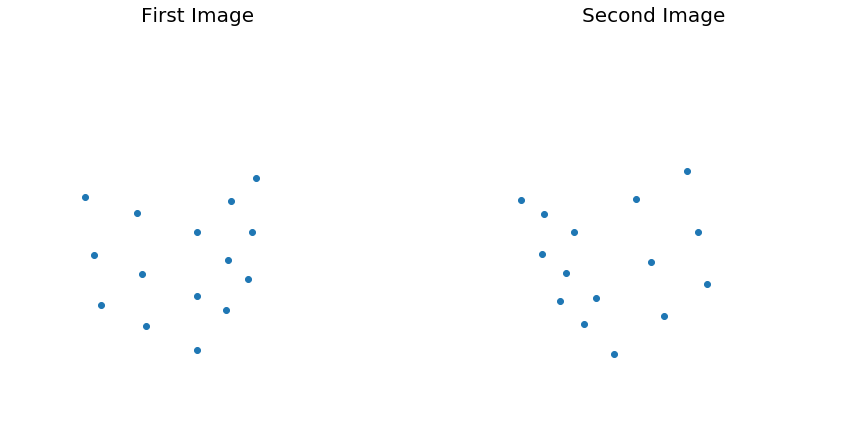

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))
axes[0].scatter(
    [x[0] for x in u_1.transpose()[:,0].tolist()],
    [300-y[0] for y in u_1.transpose()[:,1].tolist()])
axes[0].set_xlim([0, 300])
axes[0].set_ylim([0, 300])
axes[0].set_title("First Image", size=20)
axes[0].axis("off")
axes[1].scatter(
    [x[0] for x in u_2.transpose()[:,0].tolist()],
    [300-y[0] for y in u_2.transpose()[:,1].tolist()])
axes[1].set_xlim([0, 300])
axes[1].set_ylim([0, 300])
axes[1].set_title("Second Image", size=20)
axes[1].axis("off")
plt.show()

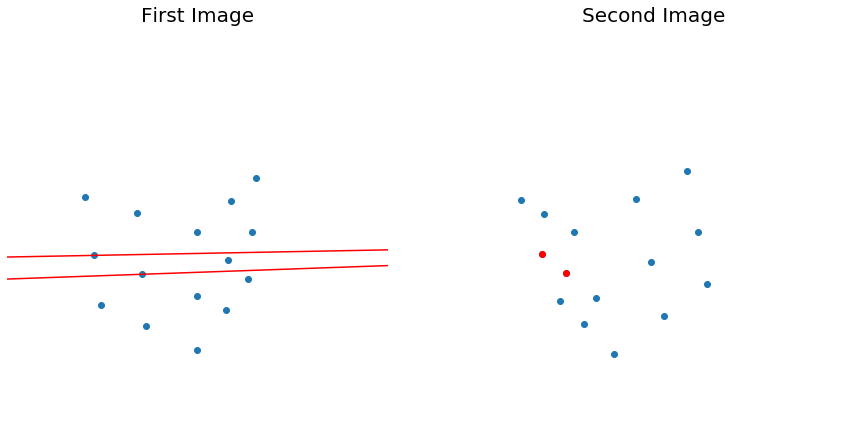

In [28]:
index = [3, 4]

if type(index) is int:
    index = list(map(int, str(index)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))
axes[0].scatter(
    [x[0] for x in u_1.transpose()[:,0].tolist()],
    [300-y[0] for y in u_1.transpose()[:,1].tolist()])
axes[0].set_xlim([0, 300])
axes[0].set_ylim([0, 300])
axes[0].set_title("First Image", size=20)
axes[0].axis("off")
axes[1].scatter(
    [x[0] for x in u_2.transpose()[:,0].tolist()],
    [300-y[0] for y in u_2.transpose()[:,1].tolist()])
for idx in index:
    axes[1].scatter(
        [x[0] for x in u_2.transpose()[:,0].tolist()][idx],
        [300-y[0] for y in u_2.transpose()[:,1].tolist()][idx],
        c="red",
        s=35
    )
    l = E * points_2[:,idx]
    error = float(points_1[:,idx].transpose() * E * points_2[:,idx])
    p_line_0 = H * np.matrix([
        [-1],
        [float((-l[2]-l[0]*(-1))/l[1])],
        [1]
    ])
    p_line_1 = H * np.matrix([
        [1],
        [float((-l[2]-l[0])/l[1])],
        [1]
    ])
    axes[0].plot(
        (float(p_line_0[0]), float(p_line_1[0])),
        (300-float(p_line_0[1]), 300-float(p_line_1[1])),
        'r-'
    )
axes[1].set_xlim([0, 300])
axes[1].set_ylim([0, 300])
axes[1].set_title("Second Image", size=20)
axes[1].axis("off")

plt.show()

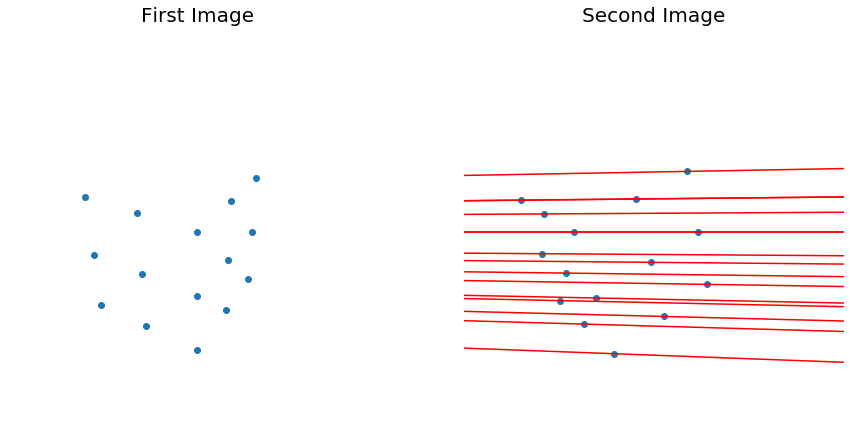

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))
axes[0].scatter(
    [x[0] for x in u_1.transpose()[:,0].tolist()],
    [300-y[0] for y in u_1.transpose()[:,1].tolist()])
axes[0].set_xlim([0, 300])
axes[0].set_ylim([0, 300])
axes[0].set_title("First Image", size=20)
axes[0].axis("off")
axes[1].scatter(
    [x[0] for x in u_2.transpose()[:,0].tolist()],
    [300-y[0] for y in u_2.transpose()[:,1].tolist()])
axes[1].set_xlim([0, 300])
axes[1].set_ylim([0, 300])
axes[1].set_title("Second Image", size=20)
axes[1].axis("off")
for index in range(0, len(points_2.transpose())):
    l = E.transpose() * points_1[:,index]
    p_line_0 = H * np.matrix([
        [-1],
        [float((-l[2]-l[0]*(-1))/l[1])],
        [1]
    ])
    p_line_1 = H * np.matrix([
        [1],
        [float((-l[2]-l[0])/l[1])],
        [1]
    ])
    axes[1].plot(
        (float(p_line_0[0]), float(p_line_1[0])),
        (300-float(p_line_0[1]), 300-float(p_line_1[1])),
        'ro-'
    )
plt.show()

## The Fundamental Matrix

With the Essential Matrix out of the way, we can now talk about the Fundamental Matrix. Before, we had corresponding points between sets of images. We know that the Essential Matrix explains the rotation and translation between these images using these points. Since the rotation and translation produce the Essential Matrix,

$$E=[t]_x R\text{,}$$

how do we find the the Essential Matrix with un-normalized image coordinates? The focal length, the camera sensor, and much more are unknown. The coordinates found in the image are only available with the intrinsic camera parameter matrix, $K$.

The image coordinates, $p_0$ and $p_1$ were normalized in the past example. We knew the focal length, $Z$. In order to find the normalized image coordinates, we can use the intrinsic camera parameter matrix, 

$$p=K^{-1}u\text{,}$$

where $u$ are the un-normalized image coordinates. 

With the un-normalized image coordinates, we can still relate the views in the set of images by using the Fundamental Matrix, $F$. Originally, we had the constraint:

$$ p^{T}_{0} E p_{1} = 0 \text{.}$$

Let

$$ 
\begin{align}
p_{1} &= K^{-1} u_{1} \\
p_{0} &= (K^{-1} u_{0})^{T} \\
      &= u_{0}^{T}K^{-T}
\end{align}
$$

so that we can relate the images using un-normalized image coordinates

$$
u_{0}^{T}K^{-T} E K^{-1} u_{1} = 0 \text{.}
$$

The center product is the Fundamental matrix:

$$
u_{0}^{T} F u_{1} = 0 \text{.}
$$

$$
F = K^{-T} E K^{-1}
$$

$$
\begin{pmatrix}x_{0} & y_{0} & 1\end{pmatrix}
\begin{pmatrix}
    F_{11} & F_{12} & F_{13} \\
    F_{21} & F_{22} & F_{23} \\
    F_{31} & F_{32} & F_{33}\end{pmatrix}
\begin{pmatrix}x_{1} \\ y_{1} \\ 1\end{pmatrix}
=0
$$

In order to solve for the Fundamental matrix, we can use SVD.

---

Using the un-normalized points, we can scale and translate the un-normalized points so that the centroid of the un-normalized points is found at the origin. We will repeat the same process as we did with the normalized points, using the un-normalized points.

In [30]:
x_n = u_1[0:2, :]
N = x_n.shape[1]
t = np.sum(x_n, axis=1) / N

Again, we find the distance from the centroid to all the centered un-normalized points, `dc`. Then, we calculate the scale factor, `s`, that we will use to scale the un-normalized points to have an average distance of $\sqrt{2}$ from the origin.

In [31]:
xnc = x_n - t * np.ones((1,N))
dc = np.sqrt(np.sum(np.power(xnc, 2).transpose(), axis=1))
d_avg = 1 / N * np.sum(dc)
s = np.sqrt(2) / d_avg

Now we can create the skew-symmetric matrix, $t$, with the scale factor and the distance from the centroid we calculated earlier.

In [32]:
t_1 = np.zeros((2, 2), float)
np.fill_diagonal(t_1, s)
t_1 = np.vstack([np.hstack([t_1, -s * t]), [0, 0, 1]])
points_1_scaled = t_1 * u_1

We repeat the process with the second set of un-normalized points.

In [33]:
x_n = u_2[0:2, :]
N = x_n.shape[1]
t = np.sum(x_n, axis=1) / N
xnc = x_n - t * np.ones((1,N))
dc = np.sqrt(np.sum(np.power(xnc, 2).transpose(), axis=1))
d_avg = 1 / N * np.sum(dc)
s = np.sqrt(2) / d_avg
t_2 = np.zeros((2, 2), float)
np.fill_diagonal(t_2, s)
t_2 = np.vstack([np.hstack([t_2, -s * t]), [0, 0, 1]])
points_2_scaled = t_2 * u_2

Now, we assemble the $A$ matrix used for the SVD process.

In [34]:
A = np.hstack([
    np.multiply(points_1_scaled[0,:].transpose(), points_2_scaled[0,:].transpose()),
    np.multiply(points_1_scaled[0,:].transpose(), points_2_scaled[1,:].transpose()),
    points_1_scaled[0,:].transpose(),
    np.multiply(points_1_scaled[1,:].transpose(), points_2_scaled[0,:].transpose()),
    np.multiply(points_1_scaled[1,:].transpose(), points_2_scaled[1,:].transpose()),
    points_1_scaled[1,:].transpose(),
    points_2_scaled[0,:].transpose(),
    points_2_scaled[1,:].transpose(),
    np.matrix(np.ones(15)).transpose()
])

Again, we can use SVD to get the last column of `V`.

In [35]:
U, D, V = np.linalg.svd(A)
F_scaled = -np.reshape(V[-1, :].tolist(), (3,3))

Now, we can force $rank(F)=2$ and equal Eigenvalues.

In [36]:
U, D, V = np.linalg.svd(F_scaled)
F_scaled = U @ np.diag([1, 1, 0]) @ V
F = t_1.transpose() @ F_scaled @ t_2